In [1]:
#############################           Dependencies            ######################################
from math import *
from math import cos as c
from math import sin as s
from random import normalvariate as normal
import numpy as np
from numpy import arange,diag,reshape,cross
from numpy.linalg import inv
import matplotlib.pyplot as plt
import seaborn as sns

#############################          Hyperparameters          ######################################
##### Constants
g=9.80655 # gravity
m=1 #quadcopter mass = 1kg
l = 0.23 #quadcopter arm length = 0.23 m

##### Quadcopter pitch_roll_yaw-rates,pitch_roll_yaw and thrust limitations (inner_loop)



max_prop_speed = 2200 # rad/s (flightGoggles value) 
thrust_coeff = 1.9 * 10**(-6) #N.s^2 (PFE auto 2016 value)
drag_coeff = 4 * 10**(-6) #N.m.s^-2 (PFE auto 2016 value)

max_thrust = 4*thrust_coeff*max_prop_speed**2  
min_thrust = 0

max_tau_phi = max_thrust*l*2
min_tau_phi = -max_tau_phi

max_tau_theta = max_thrust*l*2
min_tau_theta = -max_tau_theta

max_tau_psi = max_thrust
min_tau_psi = -max_tau_psi

max_yaw= pi # rad
min_yaw=-max_yaw

##### Controller parameters
Ppos = diag ([10 , 10 , 50]) # Pxy,Pxy,Pz
Dpos = diag ([10 , 10 , 25]) # Dxy,Dxy,Dz

Prp =10
Pyaw = 10

Ppq = 100
Pr = 10

##### Noise
a_n=0.00025 # angular process noise in rad^2/s^2
l_n=0.0005 # linear process noise in m^2/s^3

#############################            Utils functions          ####################################

def pqr_to_phidot_thetadot_psidot(p,q,r,theta,phi):
    
    phi_dot= p + q*sin(phi)*tan(theta) + r*cos(phi)*tan(theta)
    theta_dot= q*cos(phi) - r*sin(phi)
    psi_dot= q*sin(phi)/cos(theta) + r*cos(phi)/cos(theta) 
    
    return(phi_dot,theta_dot,psi_dot)

def phidot_thetadot_psidot_to_pqr(phi_dot,theta_dot,psi_dot,theta,phi):
    p=phi_dot - sin(theta)*psi_dot
    q=cos(phi)*theta_dot + sin(phi)*cos(theta)*psi_dot
    r=-sin(phi)*theta_dot + cos(phi)*cos(theta)*psi_dot
    
    return(p,q,r)

def angle_transf(angle):
    # transform angle in radians to range [-pi,pi]
    
    angle=angle%(2*pi)
    if angle > pi:
        angle=angle-2*pi
    return angle

def toEulerAngle(i,j,k,one):
    
    #code found here: https://en.wikipedia.org/wiki/Conversion_between_quaternions_and_Euler_angles
    #handle singularities here: 
    #http://www.euclideanspace.com/maths/geometry/rotations/conversions/quaternionToEuler/
    
    q_w,q_x,q_y,q_z=one,i,j,k #modified to match quaternion ordrer given by flightGoggles
    
    #roll (x-axis rotation)
    sinr_cosp = 2.0 * (q_w * q_x + q_y * q_z);
    cosr_cosp = 1.0 - 2.0 * (q_x * q_x + q_y * q_y);
    roll = atan2(sinr_cosp, cosr_cosp);

    #pitch (y-axis rotation)
    sinp = +2.0 * (q_w * q_y - q_z * q_x);
    if (fabs(sinp) >= 1):
        pitch = copysign(pi / 2, sinp); # use 90 degrees if out of range
    else:
        pitch = asin(sinp);

    #yaw (z-axis rotation)
    siny_cosp = +2.0 * (q_w * q_z + q_x * q_y);
    cosy_cosp = +1.0 - 2.0 * (q_y * q_y + q_z * q_z);  
    yaw = atan2(siny_cosp, cosy_cosp);
    
    return (pitch,roll,yaw)     

def mjtg(current, setpoint, frequency, move_time):
    trajectory = []
    trajectory_derivative = []
    timefreq = int(move_time * frequency)

    for time in range(1, timefreq+1):
        trajectory.append(
            current + (setpoint - current) *
            (10.0 * (time/timefreq)**3
             - 15.0 * (time/timefreq)**4
             + 6.0 * (time/timefreq)**5))

        trajectory_derivative.append(
            frequency * (setpoint - current) *
            (30.0 * (time)**2.0 * (1.0/timefreq)**3
             - 60.0 * (time)**3.0 * (1.0/timefreq)**4
             + 30.0 * (time)**4.0 * (1.0/timefreq)**5))

    return trajectory, trajectory_derivative

def rotation_matrix (phi,theta,psi):
        return (reshape([[c(theta)*c(psi),\
                               -c(phi)*s(psi)+s(phi)*s(theta)*c(psi),\
                                   c(phi)*s(theta)*c(psi)+s(phi)*s(psi)],\
                          [c(theta)*s(psi),\
                               c(phi)*c(psi)+s(phi)*s(theta)*s(psi),\
                                   c(phi)*s(theta)*s(psi)-s(phi)*c(psi)],\
                          [-s(theta),\
                           s(phi)*c(theta),\
                           c(phi)*c(theta)]],(3,3)))
def vex_P(R_des,R):
    # "vex" is the inverse of the skew-symmetric operator
    # "P" is the skew-symmetric projection 
    R_tilde = R_des.T @ R
    vex = reshape([R_tilde[2,1]-R_tilde[1,2],
                   R_tilde[0,2]-R_tilde[2,0],
                   R_tilde[1,0]-R_tilde[0,1],],(3,1))

    return vex.ravel()

def minmax(thrust,tau_phi,tau_theta,tau_psi):
    thrust = max(min_thrust,min(thrust,max_thrust))
    tau_phi = max(min_tau_phi,min(tau_phi,max_tau_phi))
    tau_theta = max(min_tau_theta,min(tau_theta,max_tau_theta))
    tau_psi = max(min_tau_psi,min(tau_psi,max_tau_psi))
    return (thrust,tau_phi,tau_theta,tau_psi)
    

In [2]:
class Quadcopter:
    def __init__(self,x0=0,y0=0,z0=0,phi0=0,theta0=0,psi0=0):
        
        #phi : roll , theta : pitch , yaw : psi
        self.phi=angle_transf(phi0)
        self.phi_dot=0 
         
        self.theta=angle_transf(theta0)
        self.theta_dot=0
        
        self.psi=angle_transf(psi0)
        self.psi_dot=0 
        
        self.p,self.q,self.r=phidot_thetadot_psidot_to_pqr(self.phi_dot,\
                            self.theta_dot,self.psi_dot,self.theta,self.phi)
        
        self.z=z0
        self.z_dot=0
        
        self.x=x0
        self.x_dot=0
        
        self.y=y0
        self.y_dot=0
        
        self.m=1 # vehicle mass = 1kg
        self.Jx=10**(-3) #x-Axis Moment of Inertia
        self.Jy=self.Jx #y-Axis Moment of Inertia
        self.Jz=2 * 10**(-3) #z-Axis Moment of Inertia
        self.commands=[]
    
    def __repr__(self):
        #string representation of controller class
        return "x:{} , y:{} , z:{} \npitch:{} , roll:{} , yaw:{}"\
                .format(self.x,self.y,self.z,self.theta,self.phi,self.psi)
    
    def pose(self):
        return (self.x , self.y , self.z , self.phi , self.theta , self.psi)
    
    def pose_derivative(self):
        return (self.x_dot , self.y_dot , self.z_dot\
                , self.phi_dot , self.theta_dot , self.psi_dot)
    
    def R (self):
        return rotation_matrix(self.phi,self.theta,self.psi)
    
    def move(self,thrust,tau_phi,tau_theta,tau_psi,delta_t):
        # Quadcopter dynamics using Euler's integration
        
        thrust,tau_phi,tau_theta,tau_psi = minmax(thrust,tau_phi,tau_theta,tau_psi)
        self.commands=thrust,tau_phi,tau_theta,tau_psi
        
        self.p += delta_t*(1/self.Jx)*( tau_phi + self.q * self.r *(self.Jy - self.Jz))
        self.q += delta_t*(1/self.Jy)*( tau_theta + self.p * self.r *(self.Jz - self.Jx))
        self.r += delta_t*(1/self.Jz)*( tau_psi + self.q * self.p *(self.Jx - self.Jy))
        
        self.phi_dot,self.theta_dot,self.psi_dot=\
                            pqr_to_phidot_thetadot_psidot(self.p,self.q,self.r,self.theta,self.phi) 
        
        self.phi += delta_t * self.phi_dot #+ normal(0,a_n)
        self.theta += delta_t * self.theta_dot #+ normal(0,a_n)
        self.psi+= delta_t * self.psi_dot #+ normal(0,a_n)
        
        
        self.phi,self.theta,self.psi=angle_transf(self.phi),\
        angle_transf(self.theta),angle_transf(self.psi)
        
        
        self.z_dot += delta_t*(thrust/m*cos(self.phi)*cos(self.theta) - g ) 
        self.z += delta_t*self.z_dot #+ normal(0,l_n)
        
        
        self.x_dot += delta_t*(thrust/m*(cos(self.phi)*sin(self.theta)*cos(self.psi) \
                                         +sin(self.phi)*sin(self.psi) ))
        self.x += delta_t*(self.x_dot) #+ 0.5#+ normal(0,l_n)
                                         
        
        
        self.y_dot += delta_t*(thrust/m*(cos(self.phi)*sin(self.theta)*sin(self.psi) \
                                         -sin(self.phi)*cos(self.psi) ))
        self.y += delta_t*(self.y_dot) #+ 0.5 #+ normal(0,l_n)
                                         
       

In [3]:
##############################           Main program           ######################################
# Conrol from : Quadrotor Contro for Accurate Agile Flight

# Time Parameters
dt_control_outter = 1e-2 # outter-loop control frequency [Hz] = 1/dt_control_outter
dt_control_inner = 1e-3 # inner-loop control frequency [Hz] = 1/dt_control_inner
dt_sim = 1e-4 # simulation frequency [Hz] = 1/dt_sim
outter_control_call=int(dt_control_outter/dt_sim) # call every "dt_control/dt_sim" time
inner_control_call=int(dt_control_outter/dt_sim) # call every "dt_control/dt_sim" time
simulation_time = 20 # total simulation time [s]

'''# Trajectory parameters
quadcopter = Quadcopter() # x0=0 , y0=0 , Z0=0
desired_goal = [ 10 , 10 , 10 , 0] # x,y,z,yaw
desired_trajectories = [mjtg(0,i,1/dt_sim,0.75*simulation_time) for i in desired_goal]
actual_trajectories = [] # store the state evolution'''

state = []
state_vel=[]
angles=[]
angles_vel=[]
commands=[]
test=[]

x_des,y_des,z_des,psi_des=[-1 , 1 , 1 , 0]
quadcopter = Quadcopter (x0=0,y0=0)
 
last_vex = 0
last_ep = 0
ep_i=0
# Simulation loop
for t in range(int(simulation_time/dt_sim)):
    
    ep = reshape([x_des*sin(2*t*dt_sim) - quadcopter.x,\
                  y_des*cos(2*t*dt_sim) - quadcopter.y,\
                  z_des*t*dt_sim - quadcopter.z],(3,1))
    ev = reshape([x_des *2*(cos(2*t*dt_sim)) - quadcopter.x_dot,\
                  y_des *(-2)*(sin(2*t*dt_sim)) - quadcopter.y_dot,\
                  z_des - quadcopter.z_dot],(3,1))
    ac = reshape([0,\
                  0,\
                  0],(3,1))
    
    
    mgz = reshape([0,0,m*g],(3,1))
    
    F_des = + 10*Ppos @ ep  +  10*Ppos @ ev + mgz + 0*Ppos@ac\
    + 0*np.reshape([0.1,0.1,0],(3,1))*ep_i*dt_sim\
    + 0*Dpos@(ep-last_ep)/dt_sim
    ep_i = ep_i + ep
    last_ep=ep
    
    
    

    R = quadcopter.R()
    zb = R[:,2].reshape((3,1))
    Thrust = (F_des.T @ zb).ravel()[0]
    zb_des = F_des/np.linalg.norm(F_des)
    
    xc_des = reshape([c(psi_des),s(psi_des),0],(3,1))
    zb_xc = np.cross(zb_des,xc_des,axisa=0, axisb=0).reshape((3,1))
    yb_des = zb_xc/np.linalg.norm(zb_xc)
    xb_des = np.cross(yb_des,zb_des,axisa=0, axisb=0).reshape((3,1))
    R_des = np.hstack((xb_des,yb_des,zb_des))
    
    
    vex=vex_P(R_des,R) 
    p_des,q_des,r_des = -np.array([Prp,Prp,Pyaw])*vex - 1*(vex-last_vex)/dt_sim
    last_vex = vex
    
    tau_phi = (- quadcopter.q*quadcopter.r*(quadcopter.Jy-quadcopter.Jz) \
            + Ppq*(p_des - quadcopter.p))*quadcopter.Jx
    tau_theta = (- quadcopter.p*quadcopter.r*(quadcopter.Jz-quadcopter.Jx) \
            + Ppq*(q_des - quadcopter.q))*quadcopter.Jy
    tau_psi = (- quadcopter.q*quadcopter.p*(quadcopter.Jx-quadcopter.Jy) \
            + Pr*(r_des - quadcopter.r))*quadcopter.Jz

    quadcopter.move(Thrust,tau_phi,tau_theta,tau_psi,dt_sim)
    state.append([quadcopter.x,quadcopter.y,quadcopter.z])
    state_vel.append([quadcopter.x_dot,quadcopter.y_dot,quadcopter.z_dot])
    angles.append([quadcopter.phi,quadcopter.theta,quadcopter.psi])
    angles_vel.append([quadcopter.p,quadcopter.q,quadcopter.r])
    commands.append(quadcopter.commands)
    test.append([np.trace(R_des.T@R),F_des,np.linalg.norm(zb_xc)])

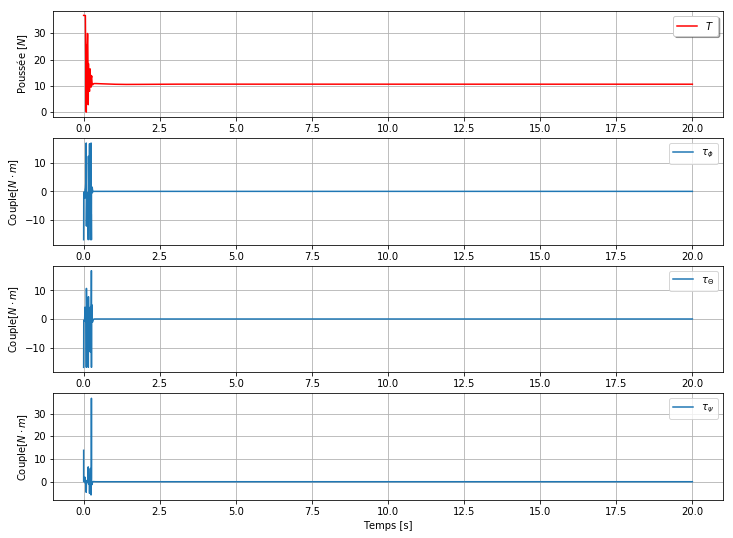

In [20]:
import importlib
importlib.reload(plt); importlib.reload(sns)
fig = plt.figure(figsize=(12, 9))

plt.subplot(411)
plt.plot(np.arange(len(commands))/len(commands)*simulation_time,np.array(commands)[:,0],color='r')
plt.grid()
plt.ylabel('Poussée [$N$]')
plt.legend((r'$T $', r'${\tau}_{\phi}$',r'$\tau_{\Theta}$', r'$\tau_{\psi} $'),
           loc='best', shadow=True)

plt.subplot(412)
#plt.plot(np.arange(len(commands))/len(commands)*simulation_time,np.array(commands)[:,1])
plt.plot(np.arange(len(commands))/len(commands)*simulation_time,\
         np.array(commands)[:,1])
plt.grid()
plt.ylabel('Couple[$N \cdot m$]')
plt.legend((r'${\tau}_{\phi}$',r'$T $', r'${\tau}_{\phi}$',r'$\tau_{\Theta}$', r'$\tau_{\psi} $'),
           loc='best')

plt.subplot(413)
plt.plot(np.arange(len(commands))/len(commands)*simulation_time,np.array(commands)[:,2])
plt.grid()
plt.ylabel('Couple[$N \cdot m$]')
plt.legend((r'$\tau_{\Theta}$',r'$T $', r'${\tau}_{\phi}$',r'$\tau_{\Theta}$', r'$\tau_{\psi} $'),
           loc='best')

plt.subplot(414)
plt.plot(np.arange(len(commands))/len(commands)*simulation_time,np.array(commands)[:,3])
plt.grid()
plt.ylabel('Couple[$N \cdot m$]')
plt.legend((r'$\tau_{\psi} $',r'$T $', r'${\tau}_{\phi}$',r'$\tau_{\Theta}$', r'$\tau_{\psi} $'),
           loc='best')


plt.xlabel('Temps [s]')


#plt.title('Évolution de la position du Quadrirotor')
#plt.savefig('simulation1.png')
#sns.reset_defaults()
plt.show()

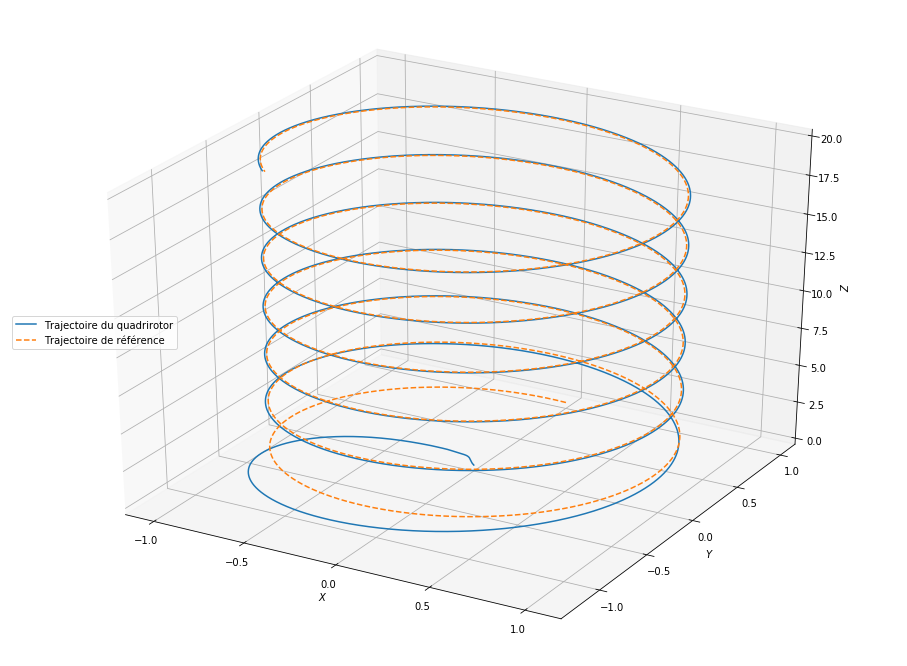

In [9]:
import importlib
importlib.reload(plt); importlib.reload(sns)
state_des=[]
x_des,y_des,z_des,psi_des=[-1 , 1 , 1 , 0]

for t in range(int(simulation_time/dt_sim)):
    
    state_des.append([x_des*sin(2*t*dt_sim) ,y_des*cos(2*t*dt_sim),z_des*t*dt_sim])
    

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
ax.plot(np.array(state)[:,0], np.array(state)[:,1], \
        zs=np.array(state)[:,2],label='Trajectoire du quadrirotor')

ax.plot(np.array(state_des)[:,0], np.array(state_des)[:,1],\
        zs=np.array(state_des)[:,2],label='Trajectoire de référence',\
       linestyle='--')
ax.legend(loc='center left')

'''plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.zlabel('Z [m]')'''
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$Z$',rotation=90)
#plt.title('Poursuite de trajectoire en spirale')


plt.show()

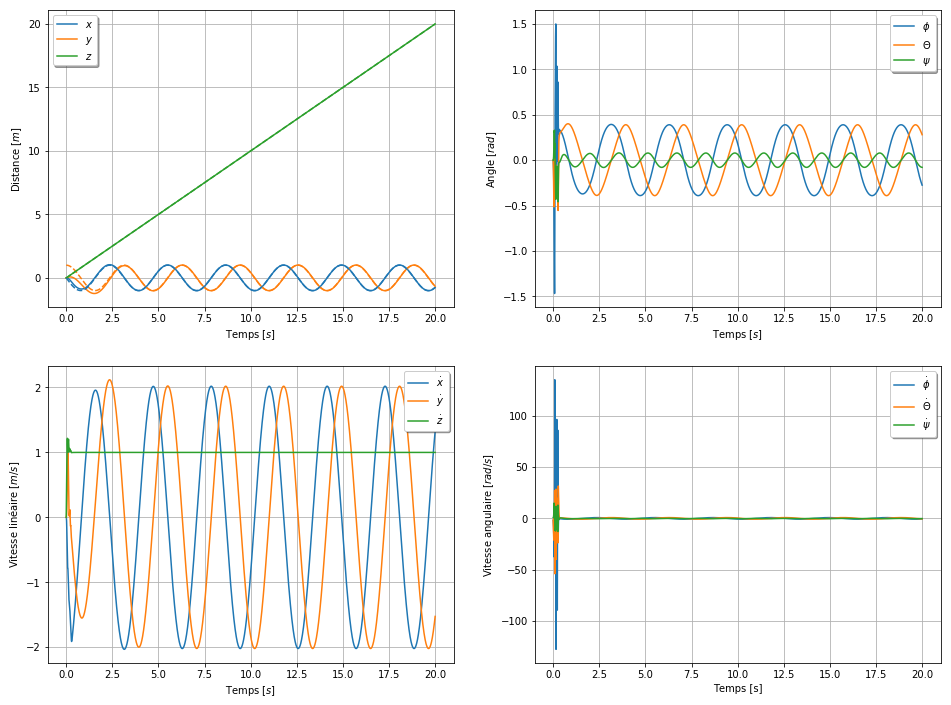

In [7]:
fig = plt.figure(figsize=(16,12))
####################
plt.subplot(2, 2, 1)
plt.plot(np.arange(len(state))/len(state)*simulation_time,np.array(state))
plt.grid()
plt.legend(('$x$', '$y$', '$z$'),
           loc='best', shadow=True)
plt.xlabel('Temps [$s$]')
plt.ylabel('Distance [$m$]')
plt.plot(np.arange(len(state))/len(state)*simulation_time,\
         [y_des*cos(2*t) for t in dt_sim*np.arange(len(state))],\
         color='tab:orange',linestyle='--')
plt.plot(np.arange(len(state))/len(state)*simulation_time,\
         [x_des*sin(2*t) for t in dt_sim*np.arange(len(state))],\
        color='tab:blue',linestyle='--')
plt.plot(np.arange(len(state))/len(state)*simulation_time,\
         [z_des*t for t in dt_sim*np.arange(len(state))],\
        color='tab:green',linestyle='--')
###################
plt.subplot(2, 2, 3)
plt.plot(np.arange(len(state_vel))/len(state_vel)*simulation_time,np.array(state_vel))
plt.grid()
plt.legend(('$\dot x$', '$\dot y$', '$\dot z$'),
           loc='best', shadow=True)
plt.xlabel('Temps [$s$]')
plt.ylabel('Vitesse linéaire [$m/s$]')

###################
plt.subplot(2, 2, 2)
plt.plot(np.arange(len(angles))/len(angles)*simulation_time,np.array(angles))
plt.grid()
plt.legend(('$\phi $', '$\Theta $', '$\psi $'),
           loc='best', shadow=True)
plt.xlabel('Temps [$s$]')
plt.ylabel('Angle [$rad$]')
###################
plt.subplot(2, 2, 4)
plt.plot(np.arange(len(angles_vel))/len(angles_vel)*simulation_time,np.array(angles_vel))

plt.grid()
plt.legend(('$\dot \phi $', '$\dot \Theta $', '$\dot \psi $'),
           loc='best', shadow=True)
plt.xlabel('Temps [s]')
plt.ylabel('Vitesse angulaire [$rad/s$]')

plt.show()